Classes: ['.ipynb_checkpoints', 'Negative', 'Positive']
Loading images...
✅ Loaded 5266 images successfully.
Training SVM classifier...
✅ Training completed.


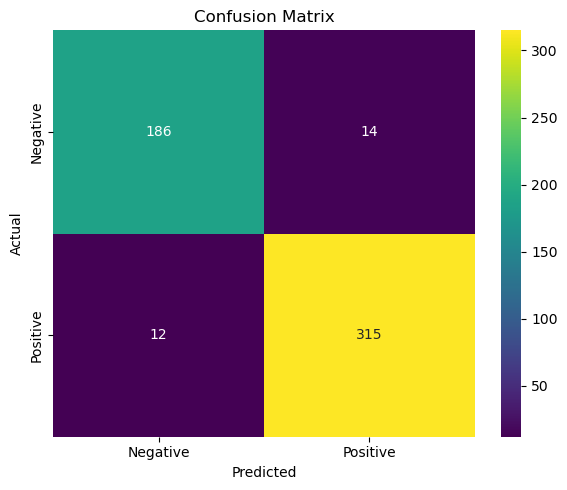

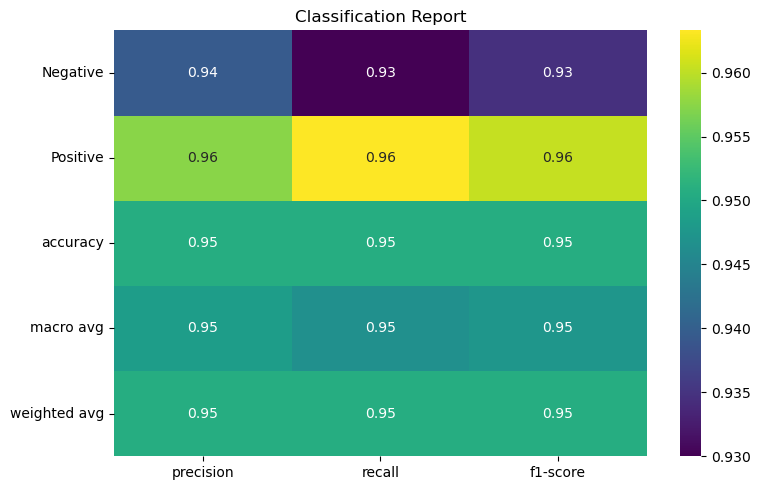

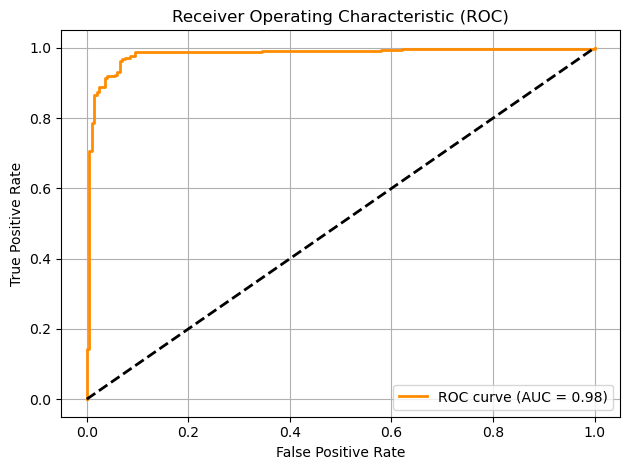

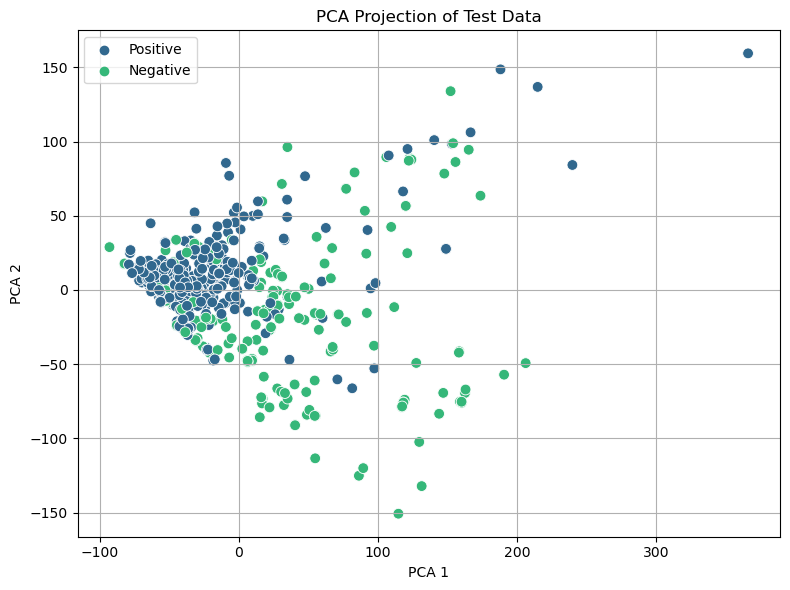

C:\Users\DEENA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\DEENA\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


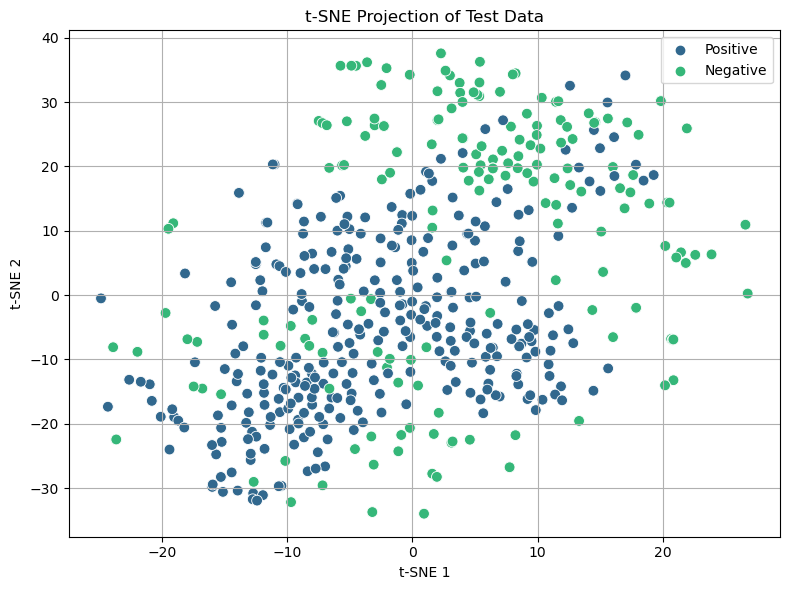

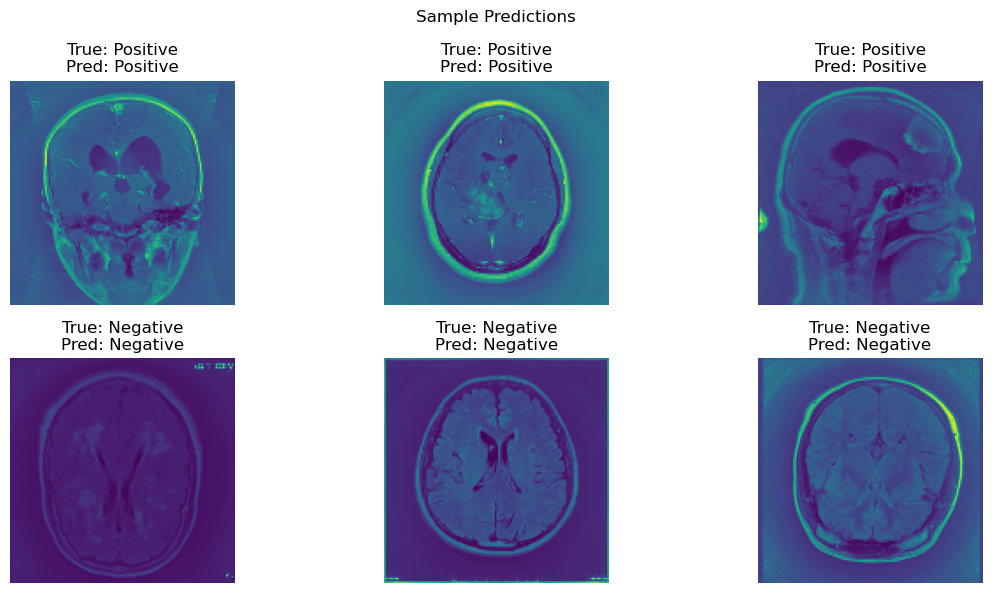

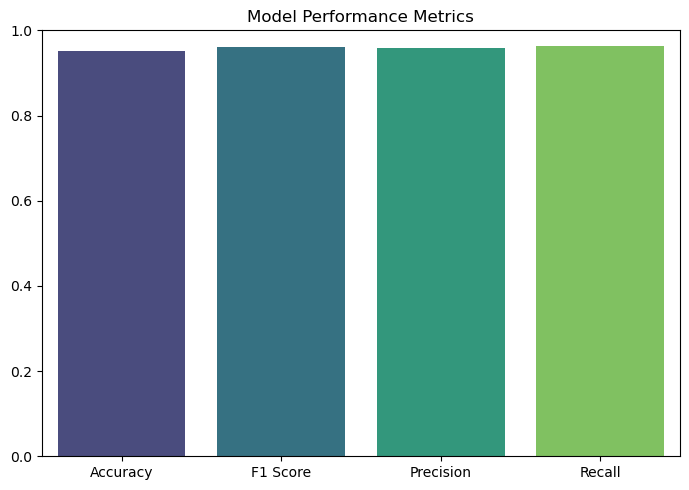

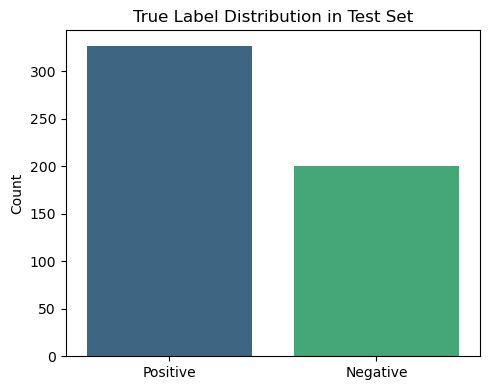

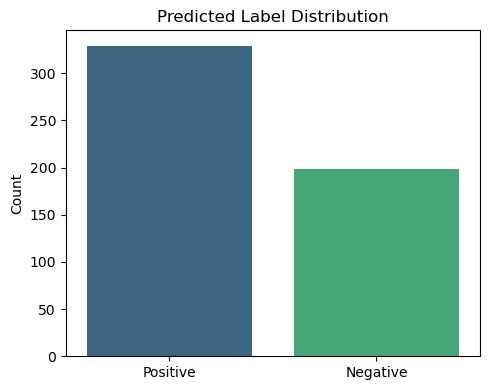

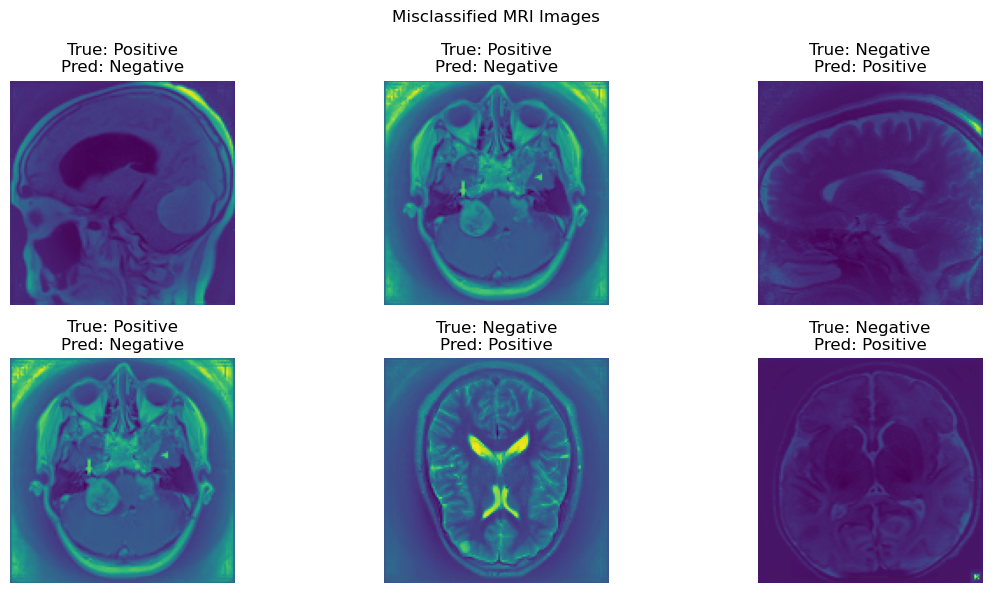

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, StandardScaler

# === CONFIG ===
IMAGE_SIZE = 128
DATASET_PATH = r"C:\Users\DEENA\Desktop\Brain_Tumor_Dataset"

# === LOAD IMAGES ===
X, y = [], []
classes = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])
print("Classes:", classes)

print("Loading images...")
for label in classes:
    cls_path = os.path.join(DATASET_PATH, label)
    for img_name in os.listdir(cls_path):
        if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        img_path = os.path.join(cls_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            print("Unreadable image:", img_path)
            continue
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img / 255.0
        X.append(img.flatten())
        y.append(label)

print(f"Loaded {len(X)} images successfully.")

# === ENCODE LABELS ===
le = LabelEncoder()
y = le.fit_transform(y)

# === SPLIT DATA ===
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# === SCALE DATA ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# === TRAIN SVM ===
print("Training SVM classifier...")
clf = SVC(kernel='linear', probability=True, random_state=42)
clf.fit(X_train, y_train)
print("Training completed.")

# === PREDICTIONS ===
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="viridis", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === CLASSIFICATION REPORT HEATMAP ===
report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
plt.figure(figsize=(8, 5))
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap="viridis")
plt.title("Classification Report")
plt.tight_layout()
plt.show()

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title("Receiver Operating Characteristic (ROC)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === PCA SCATTER ===
pca = PCA(n_components=2)
X_proj = pca.fit_transform(X_test)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_proj[:, 0], y=X_proj[:, 1], hue=le.inverse_transform(y_test), palette="viridis", s=60)
plt.title("PCA Projection of Test Data")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === t-SNE SCATTER ===
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_test)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=le.inverse_transform(y_test), palette="viridis", s=60)
plt.title("t-SNE Projection of Test Data")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === SAMPLE PREDICTIONS ===
plt.figure(figsize=(12, 6))
for i in range(6):
    img = np.array(X_test[i]).reshape(IMAGE_SIZE, IMAGE_SIZE)
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(img, cmap='viridis')
    plt.title(f"True: {le.classes_[y_test[i]]}\nPred: {le.classes_[y_pred[i]]}")
    plt.axis("off")
plt.suptitle("Sample Predictions")
plt.tight_layout()
plt.show()

# === METRIC BAR PLOT ===
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.barplot(x=["Accuracy", "F1 Score", "Precision", "Recall"], y=[acc, f1, prec, rec], palette="viridis")
plt.ylim(0, 1)
plt.title("Model Performance Metrics")
plt.tight_layout()
plt.show()

# === TRUE LABEL DISTRIBUTION ===
true_dist = pd.Series(le.inverse_transform(y_test)).value_counts()
plt.figure(figsize=(5, 4))
sns.barplot(x=true_dist.index, y=true_dist.values, palette="viridis")
plt.title("True Label Distribution in Test Set")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# === PREDICTED LABEL DISTRIBUTION ===
pred_dist = pd.Series(le.inverse_transform(y_pred)).value_counts()
plt.figure(figsize=(5, 4))
sns.barplot(x=pred_dist.index, y=pred_dist.values, palette="viridis")
plt.title("Predicted Label Distribution")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# === MISCLASSIFIED EXAMPLES ===
misclassified_idx = np.where(y_test != y_pred)[0]
plt.figure(figsize=(12, 6))
for i in range(min(6, len(misclassified_idx))):
    img = np.array(X_test[misclassified_idx[i]]).reshape(IMAGE_SIZE, IMAGE_SIZE)
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(img, cmap='viridis')
    plt.title(f"True: {le.classes_[y_test[misclassified_idx[i]]]}\nPred: {le.classes_[y_pred[misclassified_idx[i]]]}" )
    plt.axis("off")
plt.suptitle("Misclassified MRI Images")
plt.tight_layout()
plt.show()
